### 0. Prereqs

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import os
from pathlib import Path
import json

import sys

sys.path.append("scripts")

import utils
import distclassipy as dcpy

cd = dcpy.Distance()

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

classification_letter = "b"
classification_problem = settings_dict["classification_problem"][classification_letter]
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]
results_subfolder = f"{classification_letter}. {classification_problem}"
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

In [3]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

In [4]:
# Remove features to be dropped from previous notebook
with open(os.path.join("results", results_subfolder, "drop_features.txt")) as f:
    bad_features = json.load(f)  # manually selected

X_df_FULL = X_df_FULL.drop(bad_features, axis=1)

print(X_df_FULL.shape[1])

36


In [5]:
# Keep only current classes
cl_keep_str = "_".join(classes_to_keep)

y_df = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
X_df = X_df_FULL.loc[y_df.index]
X = X_df.to_numpy()
y = y_df.to_numpy().ravel()

In [6]:
with open(os.path.join("results", results_subfolder, "best_common_features.txt")) as f:
    best_common_features = json.load(f)

In [7]:
all_metrics = [
    "euclidean",
    "braycurtis",
    "canberra",
    "cityblock",
    "chebyshev",
    cd.clark,
    "correlation",
    "cosine",
    cd.hellinger,
    cd.jaccard,
    cd.lorentzian,
    cd.marylandbridge,
    cd.meehl,
    cd.motyka,
    cd.soergel,
    cd.wave_hedges,
    cd.kulczynski,
    cd.add_chisq,
]

  0%|          | 0/18 [00:00<?, ?it/s]

Euclidean
	Expected Score from training:
		F1 = 67.82 ± 3.47%
	Actual score on hidden set:
		F1 = 63.18 %


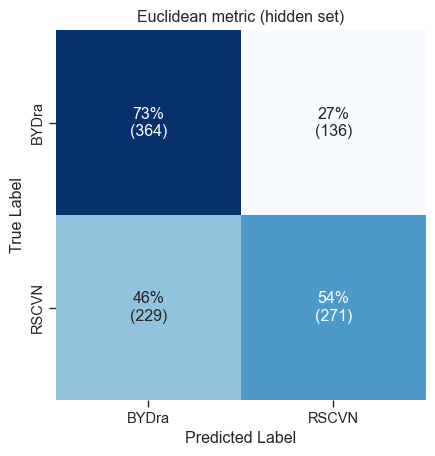

Braycurtis
	Expected Score from training:
		F1 = 65.61 ± 4.32%
	Actual score on hidden set:
		F1 = 66.77 %


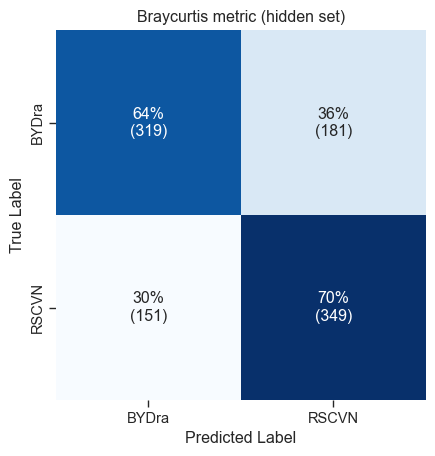

Canberra
	Expected Score from training:
		F1 = 62.08 ± 4.92%
	Actual score on hidden set:
		F1 = 62.77 %


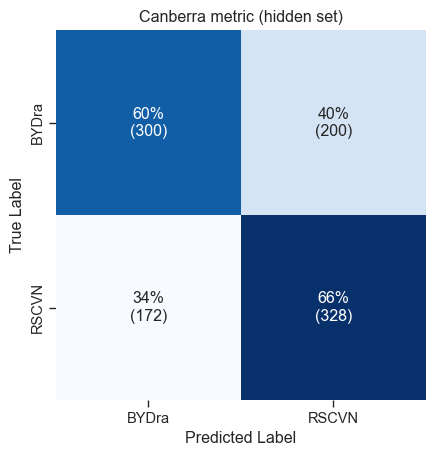

Cityblock
	Expected Score from training:
		F1 = 64.70 ± 3.10%
	Actual score on hidden set:
		F1 = 64.99 %


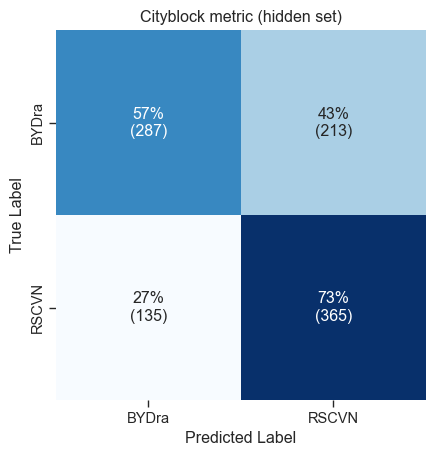

Chebyshev
	Expected Score from training:
		F1 = 67.34 ± 4.31%
	Actual score on hidden set:
		F1 = 69.60 %


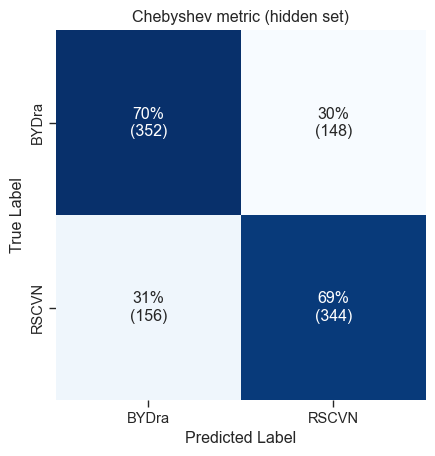

Clark
	Expected Score from training:
		F1 = 66.01 ± 3.79%
	Actual score on hidden set:
		F1 = 68.47 %


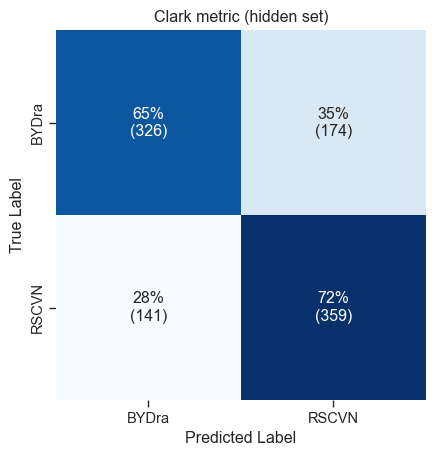

Correlation
	Expected Score from training:
		F1 = 65.71 ± 4.77%
	Actual score on hidden set:
		F1 = 62.39 %


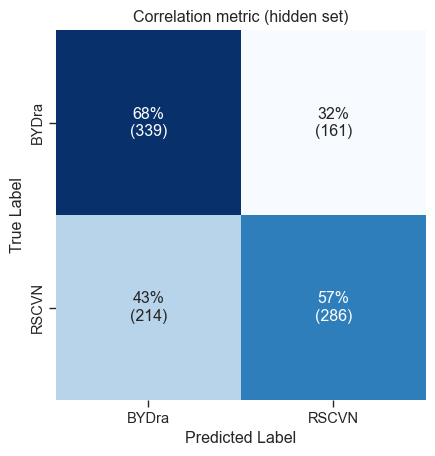

Cosine
	Expected Score from training:
		F1 = 67.25 ± 1.39%
	Actual score on hidden set:
		F1 = 64.47 %


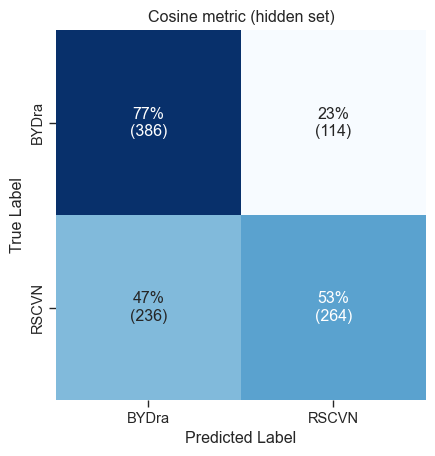

Hellinger
	Expected Score from training:
		F1 = 65.65 ± 3.95%
	Actual score on hidden set:
		F1 = 68.10 %


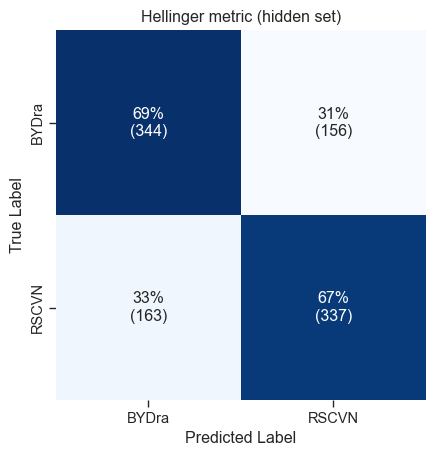

Jaccard
	Expected Score from training:
		F1 = 68.13 ± 4.12%
	Actual score on hidden set:
		F1 = 67.39 %


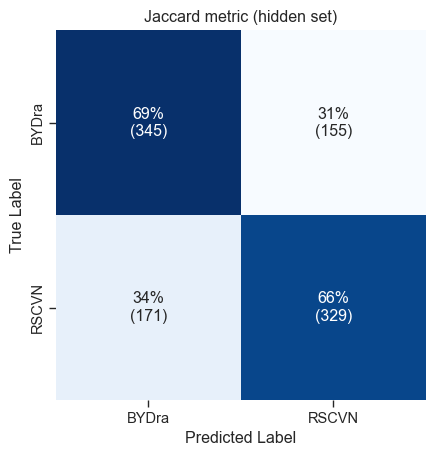

Lorentzian
	Expected Score from training:
		F1 = 63.87 ± 4.12%
	Actual score on hidden set:
		F1 = 63.89 %


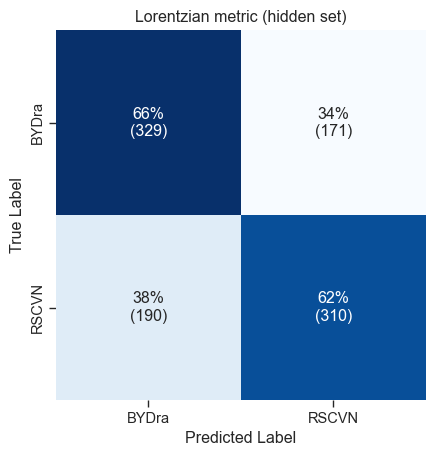

Marylandbridge
	Expected Score from training:
		F1 = 64.52 ± 3.86%
	Actual score on hidden set:
		F1 = 63.95 %


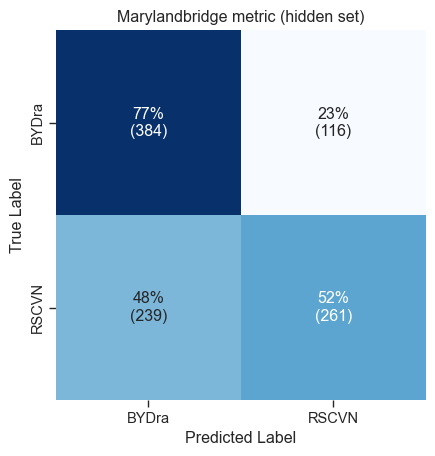

Meehl
	Expected Score from training:
		F1 = 66.43 ± 2.67%
	Actual score on hidden set:
		F1 = 64.00 %


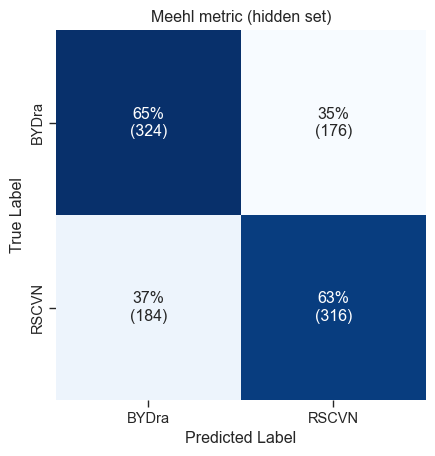

Motyka
	Expected Score from training:
		F1 = 64.21 ± 4.39%
	Actual score on hidden set:
		F1 = 65.76 %


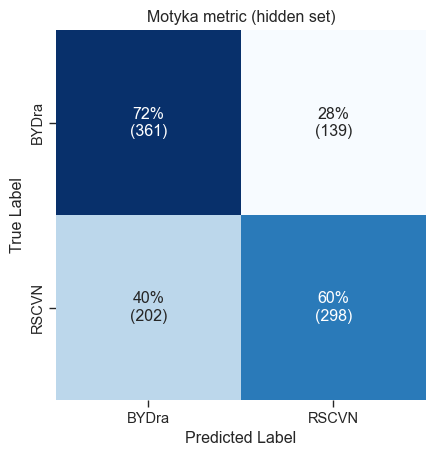

Soergel
	Expected Score from training:
		F1 = 64.21 ± 4.39%
	Actual score on hidden set:
		F1 = 65.76 %


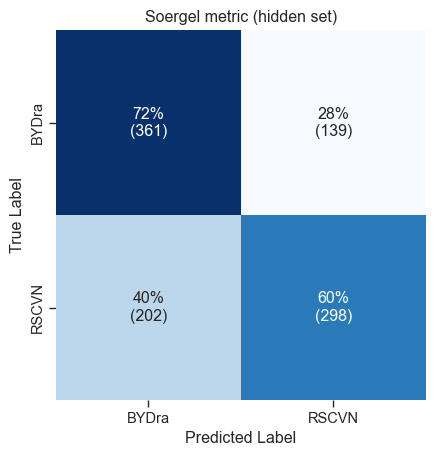

Wave_Hedges
	Expected Score from training:
		F1 = 62.08 ± 4.92%
	Actual score on hidden set:
		F1 = 62.77 %


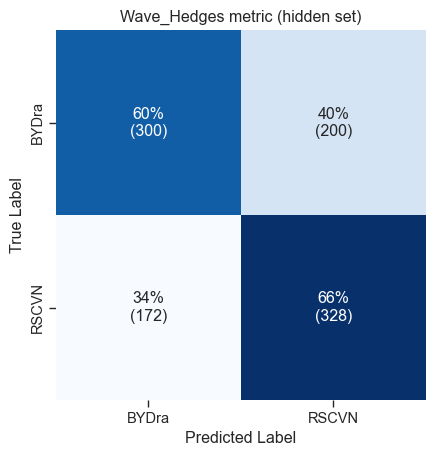

Kulczynski
	Expected Score from training:
		F1 = 64.21 ± 4.39%
	Actual score on hidden set:
		F1 = 65.76 %


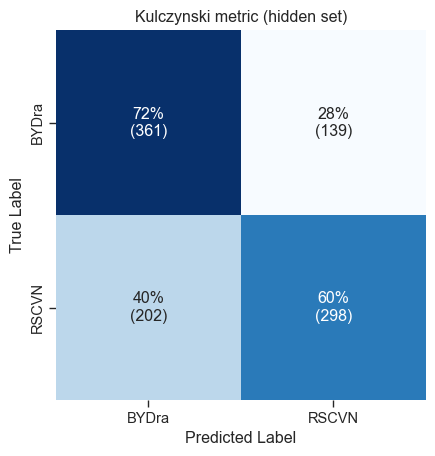

Add_Chisq
	Expected Score from training:
		F1 = 66.33 ± 3.81%
	Actual score on hidden set:
		F1 = 68.60 %


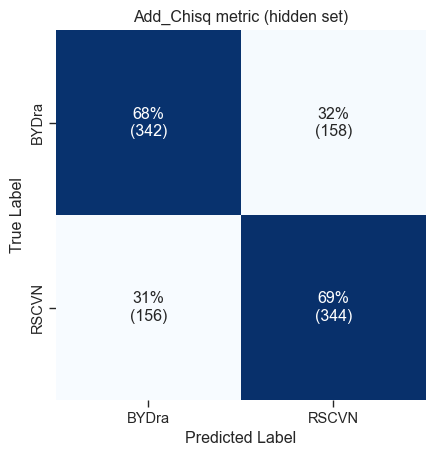

In [8]:
for metric in tqdm(all_metrics):
    metric_str = utils.get_metric_name(metric)
    locpath = os.path.join("results", results_subfolder, "distclassipy", metric_str)
    print(f"{metric_str.title()}")

    sfs_df = pd.read_csv(os.path.join(locpath, "sfs_allfeatures.csv"), index_col=0)
    feats_idx, feats = utils.load_best_features(sfs_df)

    lcdc = dcpy.DistanceMetricClassifier(
        metric=metric, scale=True, 
        central_stat=settings_dict["central_stat"], 
        dispersion_stat=settings_dict["dispersion_stat"],
        calculate_kde=False, calculate_1d_dist=False
    )

    X_df = X_df_FULL.loc[y_df.index]

    X_df = X_df.loc[:, feats]

    X = X_df.to_numpy()
    y = y_df.to_numpy().ravel()

    lcdc.fit(X, y)

    HIDDENX_df = pd.read_csv("data/HIDDENX_df_binary.csv", index_col=0)
    HIDDENy_df = pd.read_csv("data/HIDDENy_df_binary.csv", index_col=0)

    HIDDENX_df = HIDDENX_df.loc[:, feats]
    HIDDENX_df = HIDDENX_df.dropna()
    HIDDENy_df = HIDDENy_df.loc[HIDDENX_df.index]

    HIDDENX = HIDDENX_df.to_numpy()
    HIDDENy = HIDDENy_df.to_numpy().ravel()

    HIDDENy_pred = lcdc.predict_and_analyse(HIDDENX)

    acc = accuracy_score(y_true=HIDDENy, y_pred=HIDDENy_pred)
    f1score = f1_score(y_true=HIDDENy, y_pred=HIDDENy_pred, average="macro")
    matthew_coef = matthews_corrcoef(y_true=HIDDENy, y_pred=HIDDENy_pred)

    print("\tExpected Score from training:")
    print(
        f"\t\tF1 = {sfs_df.loc[len(feats)]['avg_score']*100:.2f} ± {sfs_df.loc[len(feats)]['std_dev']*100:.2f}%"
    )
    print("\tActual score on hidden set:")
    # print(f"\tAcc = {100*acc:.2f} %")
    print(f"\t\tF1 = {100*f1score:.2f} %")

    ax = utils.plot_cm(y_true=HIDDENy, y_pred=HIDDENy_pred)
    plt.title(f"{metric_str.title()} metric (hidden set)")
    plt.savefig(os.path.join(locpath, "hidden_cm.pdf"), bbox_inches="tight")
    # plt.savefig(f"hidden_cm/{metric_str}.pdf",bbox_inches = 'tight')
    plt.show()